# Training a commute prediction network, and visualizing learning!  
<ul> latest version available from: https://github.com/miroenev/teach_DL , prerequisites:
* Matplotlib, Numpy, MxNet, and <a href="https://github.com/K3D-tools/K3D-jupyter">K3D</a> for realtime training 3D surface visualization

A video walkthrough of this notebook is <a href='https://youtu.be/HgbGJn9yz30'> available on YouTube</a>.

In [ ]:
!pip install ipywidgets 
!jupyter nbextension enable --py widgetsnbextension
!pip ipydatawidgets k3d
!jupyter nbextension install --py --sys-prefix k3d
!jupyter nbextension enable --py --sys-prefix k3d

In [2]:
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import k3d

#set default figure size
plt.rcParams['figure.figsize'] = [9.5, 5]

In [3]:
%matplotlib notebook

In [4]:
import mxnet as mx

# Define the problem

Lets try to predict commute duration from two observable independent variables: the time of day and the weather conditions.

<img src='figures/commute.png' width='400'/>
<img src='figures/target_distribution.PNG' width='1000'/>
In this toy example we'll first take on the role of the 'traffic gods' and decree that commute duration is defined through a linear mixture of the two independent variables. Later we'll sample from the distribution defined by these variables and generate a training dataset. This sampling procedure will be analogous to keeping a journal of all of our commutes for some [ long ] period of time, where each log entry consists of a set of  
* <b>X</b>: [ time-of-departure, weather-condition ], and the associated  
* <b>Y</b>: [ commute-duration ].

<img src='figures/x_y_mapping.PNG' width='900'/>

Given such a journal [dataset], we'll split it into training (75%) and testing (25%) subsets which we'll use to train and evaulate our model respectively. Specifically, we'll build a neural network model whose weights are initially randomly initialized, but are trained/updated as we stream the training data through (via the backpropagation learning algorithm). Each update will get us closer to having a model that has learned the relationship between X and Y or ([ time-of-departure, weather-condition ] to [ commute-duration] ).

<img src='figures/process.PNG' width='800'/>

During the training process we'll try to visualize the network's behavior by asking it to predict all the entries in our logbook using its current parameters/weights. As the training process unfolds, you should be able to see how the network adapts itself to the target surface/function that we determined for the commute duration.

<img src='figures/training_progress.PNG' width='700'/>

# Determine underlying relationship
We'll start by esablishing (as traffic gods) the relationships between:  
* 1) the time a commute starts (time-of-departure variable) and commute-duration
* 2) the weather when a commute is started (weather-condtion variable) and commute-duration

Note that as data scientists we never get to see this function, but we try to learn it from data.

In [5]:
# define data coordinates
xRange = [0,10]; 
yRange = [0,10]; numSteps = 100

x, y = np.meshgrid( np.linspace(xRange[0], xRange[1], numSteps),
                    np.linspace(yRange[0], yRange[1], numSteps), indexing='ij' )

def normalize_domain (x):
    x = x + np.abs(np.min(x))
    x = x / (np.max(x) + .001)
    return x
    
# define 1D relationships to target
xComponent = np.sin( x ) * 4
yComponent = np.exp( y / 4 )

# define 2D joint distribution
z = xComponent + yComponent
z = normalize_domain(z)

<IPython.core.display.Javascript object>


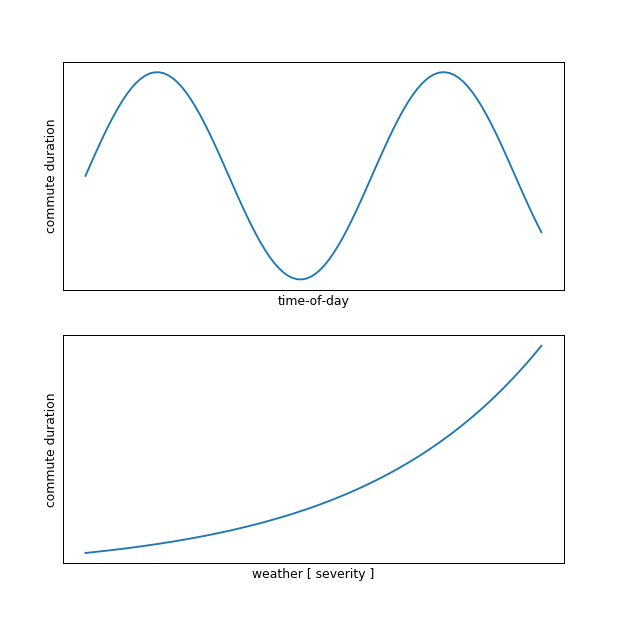

<IPython.core.display.Javascript object>


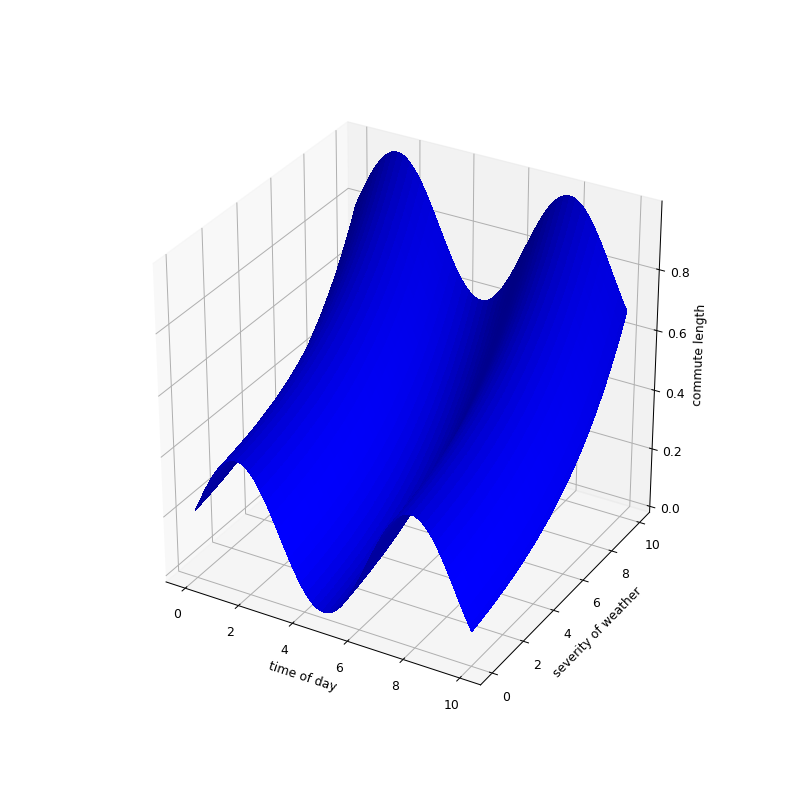

In [6]:
# plot independent variables
plt.figure( figsize = ( 7, 7) )
plt.subplots_adjust( left = 0.1, right = 0.9, top = 0.9, bottom = 0.1, wspace = 0.2 )
plt.subplot(2,1,1); plt.plot(normalize_domain(xComponent[:,0])); plt.xlabel('time-of-day'), plt.ylabel('commute duration')
plt.xticks([]), plt.yticks([])
plt.subplot(2,1,2); plt.plot(normalize_domain(yComponent[0,:])); plt.xlabel('weather [ severity ]'), plt.ylabel('commute duration')
plt.xticks([]), plt.yticks([])

# plot target [dependent] variable
plt.figure( figsize = (9, 9) )
plt.subplots_adjust( left = 0.1, right = 0.9, top = 0.9, bottom = 0.1 )
ax = plt.subplot(1,1,1, projection='3d');
ax.plot_surface ( x[0::1], y[0::1], z[0::1], color = 'blue', alpha = 1, antialiased = False )
ax.set_xlabel('time of day')
ax.set_ylabel('severity of weather')
ax.set_zlabel('commute length')
plt.show()

# Generate  dataset
Lets generate a dataset by randomly sampling from the target distribution [ with some noise ].

In [7]:
NSamples = 5000
noiseScaling = 1/8.

gpu_device=mx.gpu()

shuffledDataIndsX = np.random.randint(x.shape[0], size=(NSamples,1))
shuffledDataIndsY = np.random.randint(y.shape[0], size=(NSamples,1))

trainData = np.zeros( ( NSamples, 2 ) )
targetValues = np.zeros( (NSamples, 1 ))
noiseAmount = noiseScaling * ( np.random.rand(NSamples) - .5 )

for iSample in range (NSamples):
    trainData[iSample, 0] = x[ shuffledDataIndsX[iSample], 0 ]
    trainData[iSample, 1] = y[ 0, shuffledDataIndsY[iSample] ]    
    targetValues[iSample] = z[ shuffledDataIndsX[iSample], shuffledDataIndsY[iSample] ] + noiseAmount[iSample]

trainDataGPU = mx.nd.array(trainData, ctx=gpu_device)
targetValuesGPU = mx.nd.array(targetValues, ctx=gpu_device)

# Plot dataset samples (red dots) overlayed onto target distribution (blue)

In [8]:
def plot_3D_data (k3dPlot):
    zScaling = 5

    offset = np.hstack( ( np.ones((trainData.shape[0], 1)) * -5, 
                          np.ones((trainData.shape[0], 1)) + 4, 
                          np.zeros((trainData.shape[0], 1)) ) ) * np.abs(xRange[1]-xRange[0])

    k3dPlot += k3d.points ( np.hstack( ( trainData, targetValues*zScaling) ) + offset, color=0xFF0000, point_size = .2, shader = 'flat' )
    
    k3dPlot += k3d.surface ( np.rot90(z,3)*zScaling, color=0x0055FF, 
                            xmin=np.min(trainData[:,0]+offset[::,0]), 
                            xmax=np.max(trainData[:,0]+offset[::,0]), 
                            ymin=np.min(trainData[:,1]+offset[::,1]), 
                            ymax=np.max(trainData[:,1]+offset[::,1]))
    return zScaling, offset

plot = k3d.plot()
_, _ = plot_3D_data(plot)
plot.display()

Output()

# Create Data Iterators

In [9]:
data = trainDataGPU
label = targetValuesGPU[:,0]

trainIterator = mx.io.NDArrayIter( data = data, label = label, 
                                   data_name = 'data', 
                                   label_name = 'linearOutput_label', batch_size = 256)

predictIterator = mx.io.NDArrayIter( data = data, label = label, 
                                     data_name = 'data', 
                                     label_name = 'linearOutput_label', batch_size = NSamples)


# Define model structure

In [10]:
import mxnet as mx

inputData = mx.sym.Variable('data')
targetLabelVar = mx.sym.Variable('linearOutput_label') 

layer1 = mx.sym.FullyConnected( data = inputData, name = 'fc1', num_hidden = 5)
layer1Activation = mx.sym.Activation( data = layer1, name = 'sig1', act_type = "sigmoid")

layer2 = mx.sym.FullyConnected( data = layer1Activation, name='fc2', num_hidden = 27)
layer2Activation = mx.sym.Activation( data = layer2, name='sig2', act_type = "sigmoid")

layer3 = mx.sym.FullyConnected( data = layer2Activation, name='fc3', num_hidden = 20)
layer3Activation = mx.sym.Activation( data = layer3, name='sig3', act_type = "sigmoid")

layer4 = mx.sym.FullyConnected( data = layer3Activation, name = 'fc4', num_hidden = 40)
layer4Activation = mx.sym.Activation( data = layer4, name = 'sig4', act_type = "sigmoid")

output = mx.sym.FullyConnected( data = layer4Activation, name='output', num_hidden=1)

loss = mx.sym.LinearRegressionOutput( data = output, label = targetLabelVar , name = 'linearOutput_label')

In [11]:
mod = mx.mod.Module(symbol = loss,
                    context = mx.gpu(0),
                    data_names = ['data'],
                    label_names = ['linearOutput_label'])

In [12]:
# allocate memory given the input data and label shapes
mod.bind( data_shapes = trainIterator.provide_data, label_shapes = trainIterator.provide_label )

In [13]:
# initialize parameters by uniform random numbers
mod.init_params( initializer = mx.init.Xavier(), force_init = True)

In [14]:
# use adam optimizer
mod.init_optimizer( optimizer = 'adam' )

In [15]:
# use root mean squared error as the metric
metric = mx.metric.create( 'rmse' )

# Visualize network structure

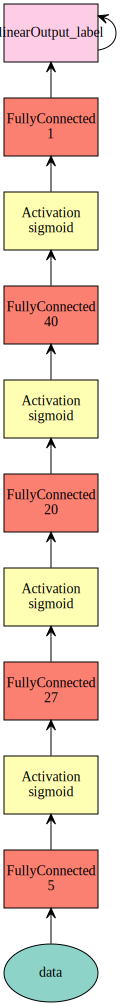

In [18]:
mx.viz.plot_network( loss )

In [19]:
import importlib
import sys
sys.path.append('utils')
import nnViz_mxnet
importlib.reload(nnViz_mxnet)

<module 'nnViz_mxnet' from 'utils/nnViz_mxnet.py'>

<IPython.core.display.Javascript object>


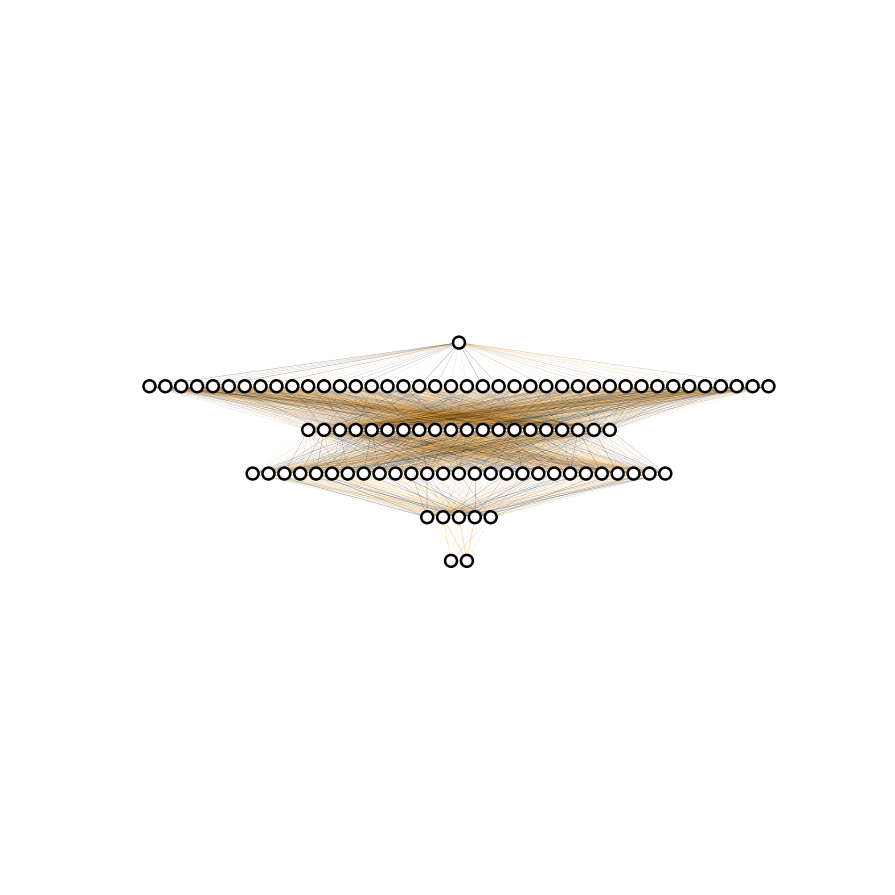

In [20]:
nnViz_mxnet.visualize_model(mod)

Model structure [loosely] inspired by NVIDIA's new HQ ;]  
http://c.ymcdn.com/sites/aiascv.org/resource/resmgr/meeting_images/2017/March/Nv2.jpeg

# Train Model Loop [ no visualization ]

In [21]:
# initialize parameters by uniform random numbers
mod.init_params( initializer = mx.init.Xavier(), force_init = True)

In [22]:
import time
startTime = time.time()
for epoch in range(300):
    
    trainIterator.reset()
    metric.reset()
    
    for batch in trainIterator:
        
        mod.forward( batch, is_train = True )       # compute predictions
        mod.update_metric( metric, batch.label )    # accumulate prediction accuracy
        mod.backward()                              # compute gradients
        mod.update()                                # update parameters
    
    print('Epoch %d, Training %s' % (epoch, metric.get()))
elapsedTime = time.time() - startTime
print(elapsedTime)

Epoch 0, Training ('rmse', 0.2862948514521122)
Epoch 1, Training ('rmse', 0.22881371825933455)
Epoch 2, Training ('rmse', 0.21994916871190071)
Epoch 3, Training ('rmse', 0.21368831321597098)
Epoch 4, Training ('rmse', 0.19389008954167367)
Epoch 5, Training ('rmse', 0.17158392593264579)
Epoch 6, Training ('rmse', 0.16210833415389062)
Epoch 7, Training ('rmse', 0.15418473184108733)
Epoch 8, Training ('rmse', 0.15024415999650956)
Epoch 9, Training ('rmse', 0.14934366345405578)
Epoch 10, Training ('rmse', 0.14885307848453522)
Epoch 11, Training ('rmse', 0.14812005683779716)
Epoch 12, Training ('rmse', 0.14734908565878868)
Epoch 13, Training ('rmse', 0.14648305773735046)
Epoch 14, Training ('rmse', 0.1455731987953186)
Epoch 15, Training ('rmse', 0.14488036632537843)
Epoch 16, Training ('rmse', 0.14425259456038475)
Epoch 17, Training ('rmse', 0.14354997351765633)
Epoch 18, Training ('rmse', 0.14276299104094506)
Epoch 19, Training ('rmse', 0.14190833643078804)
Epoch 20, Training ('rmse', 0.14

Epoch 168, Training ('rmse', 0.062780813314020634)
Epoch 169, Training ('rmse', 0.062662183865904802)
Epoch 170, Training ('rmse', 0.062544191256165504)
Epoch 171, Training ('rmse', 0.06242672931402922)
Epoch 172, Training ('rmse', 0.062309936620295048)
Epoch 173, Training ('rmse', 0.062193736806511878)
Epoch 174, Training ('rmse', 0.062078028917312622)
Epoch 175, Training ('rmse', 0.061962794885039328)
Epoch 176, Training ('rmse', 0.061848138086497785)
Epoch 177, Training ('rmse', 0.061733946762979032)
Epoch 178, Training ('rmse', 0.061620156094431874)
Epoch 179, Training ('rmse', 0.061506813764572142)
Epoch 180, Training ('rmse', 0.061393864639103415)
Epoch 181, Training ('rmse', 0.06128132548183203)
Epoch 182, Training ('rmse', 0.06116907801479101)
Epoch 183, Training ('rmse', 0.061057137884199621)
Epoch 184, Training ('rmse', 0.060945544764399527)
Epoch 185, Training ('rmse', 0.060834232531487939)
Epoch 186, Training ('rmse', 0.060723212361335752)
Epoch 187, Training ('rmse', 0.060

# Train Model + Visualize

In [23]:
# initialize parameters by uniform random numbers
mod.init_params( initializer = mx.init.Xavier(), force_init = True)

In [24]:

NEpochs = 350
displayUpdateInterval = 10


currentNN = {}
plotCount = 0

xOffset = np.zeros( (trainData.shape[0], 1))
yOffset = np.zeros( (trainData.shape[0], 1))
zOffset = np.zeros( (trainData.shape[0], 1))

xModifier = 1 * np.abs(xRange[1]-xRange[0])*1.2; yModifier = 0; zModifier = 0; 
plotCount = 0

evalLoss = np.empty((NEpochs))
evalLoss[:] = np.NaN

predictIterator.reset()
nextIterData = predictIterator.next()
batchInputs = nextIterData.data[0].asnumpy()

# 3D plot
plot = k3d.plot()
zScaling, offset = plot_3D_data(plot)
plot.display()

# train 5 epochs, i.e. going over the data iter one pass
for iEpoch in range(NEpochs):
    
    trainIterator.reset()
    metric.reset()
    
    for batch in trainIterator:
        mod.forward( batch, is_train = True )     # compute predictions
        mod.update_metric( metric, batch.label )  # accumulate prediction accuracy
        mod.backward()                            # compute gradients
        mod.update()                              # update parameters
    
    evalLoss[iEpoch] = metric.get()[1]
    print('Epoch: %d, Training Loss: %s' % ( iEpoch, evalLoss[iEpoch] ))
    
    
    # plotting 
    if iEpoch % displayUpdateInterval == 0:
        
        mod.forward( nextIterData )
        
        currentNN[plotCount] = mod.get_outputs()[0].asnumpy()

        comboOffset = np.hstack( (xOffset + xModifier, yOffset + yModifier, zOffset + zModifier) )
        plot += k3d.points ( np.hstack( ( batchInputs, currentNN[plotCount] * zScaling) ) + comboOffset + offset, color=0xA9A9FF, point_size = .2, shader = 'flat' )        
        #plot += K3D.text ( str( round( evalLoss[iEpoch], 4 )), 
        #                  (comboOffset + offset + (0, 0, 3)), color=0xff00ff, size=.5, reference_point='rb')
        
        
        plotCount += 1
        if plotCount % 8 == 0:
            xModifier = 1 * np.abs(xRange[1]-xRange[0])*1.2
            yModifier -= 1 * np.abs(yRange[1]-yRange[0])*1.2
        else:
            xModifier += 1 * np.abs(xRange[1]-xRange[0])*1.2

Output()

Epoch: 0, Training Loss: 0.493656161427
Epoch: 1, Training Loss: 0.248492574692
Epoch: 2, Training Loss: 0.224285826832
Epoch: 3, Training Loss: 0.221388202906
Epoch: 4, Training Loss: 0.220526380092
Epoch: 5, Training Loss: 0.220125368237
Epoch: 6, Training Loss: 0.219812614471
Epoch: 7, Training Loss: 0.219315310568
Epoch: 8, Training Loss: 0.218509198725
Epoch: 9, Training Loss: 0.217127406597
Epoch: 10, Training Loss: 0.214546333253
Epoch: 11, Training Loss: 0.209495130926
Epoch: 12, Training Loss: 0.200070095807
Epoch: 13, Training Loss: 0.187420904636
Epoch: 14, Training Loss: 0.178808429837
Epoch: 15, Training Loss: 0.173699701577
Epoch: 16, Training Loss: 0.168388387561
Epoch: 17, Training Loss: 0.163969157636
Epoch: 18, Training Loss: 0.160441566259
Epoch: 19, Training Loss: 0.15732043609
Epoch: 20, Training Loss: 0.154372484982
Epoch: 21, Training Loss: 0.151535113156
Epoch: 22, Training Loss: 0.148825924844
Epoch: 23, Training Loss: 0.146304878592
Epoch: 24, Training Loss: 0

Epoch: 198, Training Loss: 0.0698268119246
Epoch: 199, Training Loss: 0.0692622348666
Epoch: 200, Training Loss: 0.0686500314623
Epoch: 201, Training Loss: 0.0680520959198
Epoch: 202, Training Loss: 0.0675017911941
Epoch: 203, Training Loss: 0.0669659325853
Epoch: 204, Training Loss: 0.0664157159626
Epoch: 205, Training Loss: 0.0658483946696
Epoch: 206, Training Loss: 0.0652912417427
Epoch: 207, Training Loss: 0.0647923529148
Epoch: 208, Training Loss: 0.0642620034516
Epoch: 209, Training Loss: 0.0632081311196
Epoch: 210, Training Loss: 0.0612502492964
Epoch: 211, Training Loss: 0.0586156444624
Epoch: 212, Training Loss: 0.0558475613594
Epoch: 213, Training Loss: 0.0540360154584
Epoch: 214, Training Loss: 0.0533346744254
Epoch: 215, Training Loss: 0.0525012886152
Epoch: 216, Training Loss: 0.0515437074006
Epoch: 217, Training Loss: 0.0507612250745
Epoch: 218, Training Loss: 0.0500944400206
Epoch: 219, Training Loss: 0.0495385928079
Epoch: 220, Training Loss: 0.0490653023124
Epoch: 221,

<IPython.core.display.Javascript object>


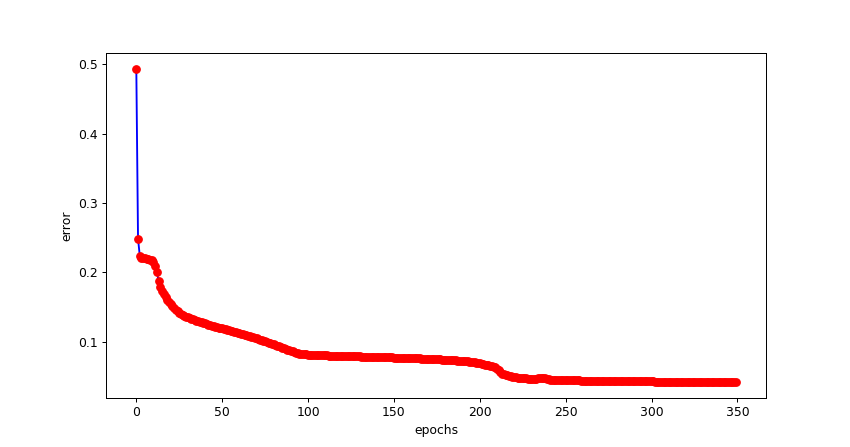

Text(0,0.5,'error')

In [25]:
plt.figure()
plt.plot(evalLoss[:], 'b')
plt.plot(evalLoss[:], 'or')
plt.xlabel('epochs')
plt.ylabel('error')

# Plot Predictions Before Training

In [26]:
plot = k3d.plot()
plot += k3d.points ( np.hstack( ( batchInputs, currentNN[0]*zScaling) ), color=0xFF00FF, point_size = .3, shader = 'flat' )        
plot += k3d.surface ( np.rot90(z,3) * zScaling, color=0x888888, xmin=np.min(xRange), xmax=np.max(xRange), ymin=np.min(yRange), ymax=np.max(yRange))
plot.display()

Output()

# Plot Predictions Midway Through Training

In [27]:
plot = k3d.plot()
plot += k3d.points ( np.hstack( ( batchInputs, currentNN[int(plotCount/2)]*zScaling) ), color=0xFF00FF, point_size = .3, shader = 'flat' )        
plot += k3d.surface ( np.rot90(z,3) * zScaling, color=0x888888, xmin=np.min(xRange), xmax=np.max(xRange), ymin=np.min(yRange), ymax=np.max(yRange))
plot.display()

Output()

# Plot Predictions at End of Training

In [28]:
plot = k3d.plot()
plot += k3d.points ( np.hstack( ( batchInputs, currentNN[int(plotCount-1)]*zScaling) ), color=0xFF00FF, point_size = .3, shader = 'flat' )        
plot += k3d.surface ( np.rot90(z,3) * zScaling, color=0x888888, xmin=np.min(xRange), xmax=np.max(xRange), ymin=np.min(yRange), ymax=np.max(yRange))
plot.display()

Output()

## thanks!